In [1]:
import os
import pandas as pd
import qiime2 as q2
import numpy as np
import seaborn as sns

from skbio import OrdinationResults
from biom import load_table, Table
from qiime2.plugins.gemelli.actions import ctf
from gemelli.rpca import rpca
from qiime2.plugins.longitudinal.actions import volatility

# stats tests
from scipy.linalg import norm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import wilcoxon, ttest_ind, f_oneway, ttest_rel
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.stats.multitest import multipletests

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

# warnings filter 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

plt.style.use('ggplot')
%matplotlib inline

### load and preprocess data

In [2]:
# time splits
ctf_splits = {}

splits_ = {#'all':[0.0, 1.0, 2.0, 7.0, 14.0, 
           #       21.0, 30.0, 60.0, 90.0, 120.0, 
           #       150.0, 180.0, 210.0, 240.0, 
           #       270.0, 300.0, 330.0, 360.0],
           '0-2':[0.0, 1.0, 2.0],
           '7-360':[7.0, 14.0, 30.0,
                    60, 120, 180, 360]}

#for body_site in ['Baby-Feces', 'Baby-Mouth', 'Baby-Forearm']:
for body_site in ['Baby-Feces']:

    print("## %s ##" % body_site)

    for t_range_, t_use in splits_.items():

        print("# tps:", len(t_use))
        # import metadata
        #mf_tmp = q2.Metadata.load('../data/split-data/%s/metadata.qza' % body_site).to_dataframe()
        mf_tmp = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)

        ### early daily samples ## 
        mf_tmp['date_sampling_category_days_continuous'] = mf_tmp.date_sampling_category_days_continuous.astype(float)
        mf_tmp = mf_tmp[mf_tmp.date_sampling_category_days_continuous.isin(t_use)]

        # build map of total subjects
        sdtypedf_ = mf_tmp[~mf_tmp.country.isin(['PuertoRico'])].dropna(subset=['country'])
        subsject_time_ = pd.concat({s_:pd.DataFrame(set(sdf_.date_sampling_category_days_continuous))
                                    for s_, sdf_ in sdtypedf_.groupby('subjectid_unique')})
        subsject_time_ = subsject_time_.reset_index().drop('level_1', axis=1)
        subsject_time_.columns = ['subject','month']
        subsject_time_['exist'] = 1
        
        # stack into map
        subsject_time_ = subsject_time_.pivot(index='subject',
                                          columns='month',
                                          values='exist').fillna(0)
        use_subjects = subsject_time_.index[subsject_time_.sum(1) >= len(t_use) - 2]
        mf_tmp = mf_tmp[mf_tmp.subjectid_unique.isin(use_subjects)]
        print("# subjects:", len(use_subjects))
        print("# samples:", mf_tmp.shape[0])

        # subset fecal
        bt_tmp = load_table('../data/%s/table-filtered.biom' % body_site).copy()

        # pre-filter tables
        bt_tmp = bt_tmp.filter(bt_tmp.ids()[bt_tmp.sum('sample') > 0])
        freq_filts = bt_tmp.matrix_data.toarray().sum(axis=1) \
                      > 10 # 10
        bt_tmp = bt_tmp.filter(bt_tmp.ids('observation')[freq_filts], axis='observation')

        # subset shared 
        shared_ = set(bt_tmp.ids()) & set(mf_tmp.index)
        bt_tmp = bt_tmp.filter(shared_)
        mf_tmp = mf_tmp.reindex(shared_)

        # save the splits
        ctf_splits[(body_site, t_range_)] = [bt_tmp, mf_tmp]
    print()

## Baby-Feces ##
# tps: 3
# subjects: 131
# samples: 197
# tps: 7
# subjects: 66
# samples: 384



### Baby-Feces:

**Time 0-2:**
- Subjects: 131 vs. 143
- Samples: 197 vs. 223

**Time 7-360:**
- Subjects: 66 vs. 67
- Samples: 384 vs. 402

### Baby-Mouth:

**Time 0-2:**
- Subjects: 74 vs. 75
- Samples: 175 vs. 190

**Time 7-360:**
- Subjects: 43 vs. 43
- Samples: 269 vs. 273

### Baby-Forearm:

**Time 0-2:**
- Subjects: 67 vs. 69
- Samples: 163 vs. 173

**Time 7-360:**
- Subjects: 36 vs. 40
- Samples: 230 vs. 256

In [3]:
for (body_site, t_range_), (bt_tmp, mf_tmp) in ctf_splits.items():

    # import into qiime2
    print((body_site, t_range_))
    q2bt_tmp =  q2.Artifact.import_data('FeatureTable[Frequency]', bt_tmp)
    q2mf_tmp = q2.Metadata(mf_tmp)
    # run ctf
    fecal_res = ctf(q2bt_tmp,
                    q2mf_tmp,
                    'subjectid_unique',
                    'date_sampling_category_days_continuous')
    # save split
    #directory = '../results/ctf-results/%s-%s' % (body_site, t_range_)
    #if not os.path.exists(directory):
    #    os.mkdir(directory)
    #q2bt_tmp.save('%s/%s' % (directory, 'table.qza'))
    #q2mf_tmp.save('%s/%s' % (directory, 'metadata.qza'))
    #for name_, art_ in fecal_res.__dict__.items():
    #    if name_ != '_fields':
    #        art_.save('%s/%s' % (directory, name_))
    print()

('Baby-Feces', '0-2')


current condition: (3, 3)
component #2
loads[0][:, [component]]: (131, 1)
condition[:, [component]].T: (1, 3)
dtmp: (393,)
component #1
loads[0][:, [component]]: (131, 1)
condition[:, [component]].T: (1, 3)
dtmp: (393,)
component #0
loads[0][:, [component]]: (131, 1)
condition[:, [component]].T: (1, 3)
dtmp: (393,)
subject_temp_trajectory: (393, 3)
self.subject_trajectory: 1

('Baby-Feces', '7-360')
current condition: (7, 3)
component #2
loads[0][:, [component]]: (66, 1)
condition[:, [component]].T: (1, 7)
dtmp: (462,)
component #1
loads[0][:, [component]]: (66, 1)
condition[:, [component]].T: (1, 7)
dtmp: (462,)
component #0
loads[0][:, [component]]: (66, 1)
condition[:, [component]].T: (1, 7)
dtmp: (462,)
subject_temp_trajectory: (462, 3)
self.subject_trajectory: 1



In [ ]:
for (body_site, t_range_), (bt_tmp, mf_tmp) in ctf_splits.items():

    # import into qiime2
    print((body_site, t_range_))
    q2bt_tmp =  q2.Artifact.import_data('FeatureTable[Frequency]', bt_tmp)
    q2mf_tmp = q2.Metadata(mf_tmp)
    # run ctf
    fecal_res = ctf(q2bt_tmp,
                    q2mf_tmp,
                    'subjectid_unique',
                    'date_sampling_category_days_continuous')
    # save split
    directory = '../results/ctf-results/%s-%s' % (body_site, t_range_)
    if not os.path.exists(directory):
        os.mkdir(directory)
    q2bt_tmp.save('%s/%s' % (directory, 'table.qza'))
    q2mf_tmp.save('%s/%s' % (directory, 'metadata.qza'))
    for name_, art_ in fecal_res.__dict__.items():
        if name_ != '_fields':
            art_.save('%s/%s' % (directory, name_))

### Analysis

In [2]:
def temporal_plot(x_axis, y_axis, df, ax, title, x_label, y_label,
                  title_fontsize, x_fontsize, y_fontsize, hue=None,
                  style=None, size=None, min_x = 0, max_x = 35, err_style='band', 
                  ci=95, cmap='tab10', style_order=None, dashes_=True,
                  style_order_ = ['CSseed','Vag','CS']):

    """

    This wrapper creates beautiful timeseries plots using
    seaborn and matplotlib. 

    Parameters
    ----------
    x_axis : str, required
        X-axis catagory in dataframe -- data
        
    y_axis : str, required
        y-axis catagory in dataframe -- data
        
    df : dataframe, required
        dataframe of data to plot
    
    ax : matplotlib figure object, required
        panel object from matplotlib figure 
    
    title : str, required
        panel title
    
    x_label : str, required
        x label panel title
    
    y_label : str, required
        y label panel title
        
    title_fontsize : int, required
    x_fontsize : int, required
    y_fontsize : int, required
        font sizes 
    
    hue : str, optional
        color by catagory in dataframe -- data
        
    style : str, optional
        style by catagory in dataframe -- data
    
    Returns
    ----------
    matplotlib figure object

    """

    # Lineplot across time 
    sns.lineplot(x=x_axis,
                 y=y_axis,
                 hue=hue,
                 style=style,
                 dashes=dashes_,
                 style_order=style_order_,
                 ci=ci,
                 sort=True,
                 markers=['o','o','o'],
                 estimator=np.mean,
                 err_style=err_style,
                 palette=cmap,
                 data=df,
                 ax=ax)
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(x_label, color='#000000',
                  fontsize=x_fontsize)
    ax.set_ylabel(y_label, color='#000000',
                  fontsize=y_fontsize, labelpad=0)
    
    # remove all grids, backrounds etc ...
    ax.legend_.remove()        
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(min_x, max_x)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax

In [3]:
# location of stored results
ctf_results = {}
# import CTF results and data
for body_site in ['Baby-Feces', 'Baby-Mouth', 'Baby-Forearm']:
    
    for t_range_ in ['all', '0-2', '7-360']:

        directory = '../results/ctf-results/%s-%s' % (body_site, t_range_)
        # all imports
        trajectory_ = q2.Artifact.load('%s/%s' % (directory, 'state_subject_ordination.qza'))
        biplot_ = q2.Artifact.load('%s/%s' % (directory, 'subject_biplot.qza'))
        distance_ = q2.Artifact.load('%s/%s' % (directory, 'distance_matrix.qza'))
        table_ = q2.Artifact.load('%s/%s' % (directory, 'table.qza'))
        metadata_ = q2.Metadata.load('%s/%s' % (directory, 'metadata.qza'))
        # save results to dict
        res_ = {'trajectory':trajectory_,
                'biplot':biplot_,
                'distance':distance_,
                'table':table_,
                'metadata':metadata_}
        ctf_results[(body_site, t_range_)] = res_

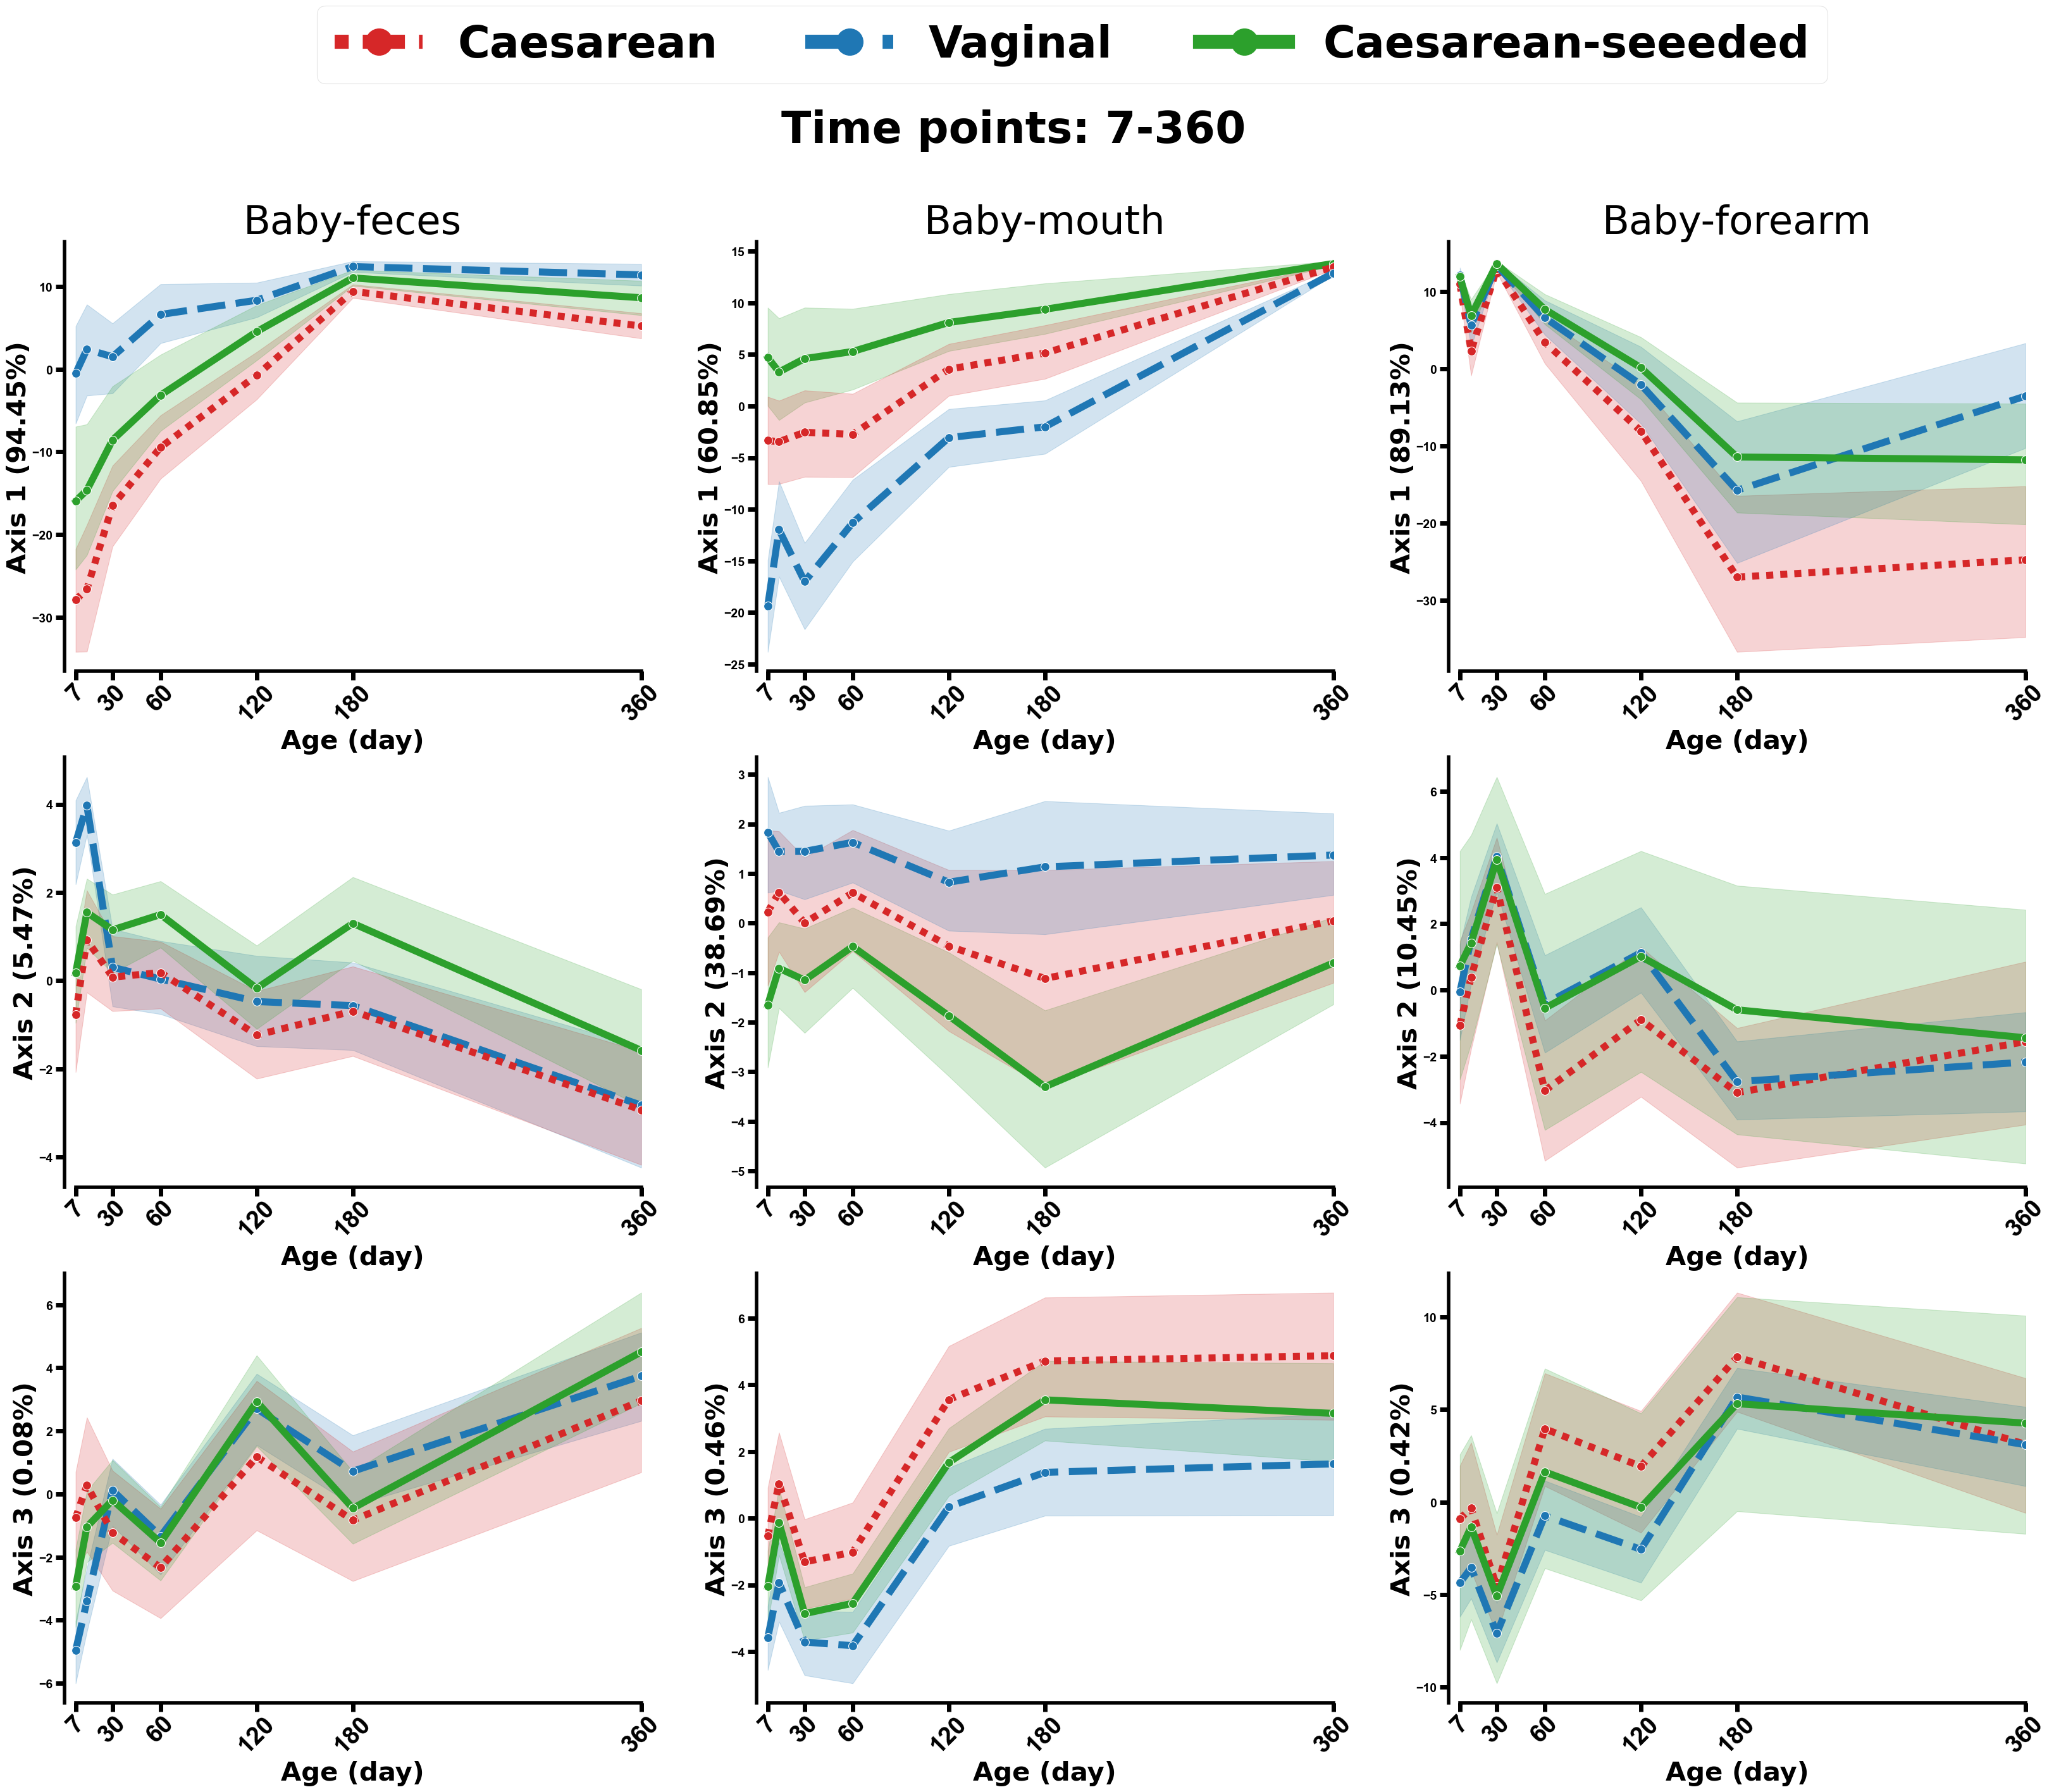

In [5]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 8, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)  
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

fig, axn = plt.subplots(3,3, figsize=(40,30))

color_by = 'birth_mode_ms'
time_ = 'date_sampling_category_days_continuous'
cmap_bm = {'CS':'#e41a1c', #red
           'CSseed':'#4daf4a', #green
           'Vag':'#377eb8'} #blue
cmap_bia = {'CSseed':'tab:green', 
            'Vag':'tab:blue', 
            'CS':'tab:red'}

stypes = ['Baby-Feces','Baby-Mouth','Baby-Forearm']
t_range_ = '7-360' #'all', '0-2', '7-360'
pc_sum = {}

for i, component in enumerate(['PC1','PC2','PC3']):
    
    for stype_, (j, value_y) in zip(stypes, enumerate([component, component, component])):
        sub_trajs_plot = ctf_results[(stype_, t_range_)]['trajectory'].view(pd.DataFrame).copy()
        propexp = ctf_results[(stype_, t_range_)]['biplot'].view(OrdinationResults).proportion_explained
        PC_label = 'Axis {}'.format(i+1) + ' (%.2f%%)'%(propexp[i] * 100)
        if  stype_ == 'skin':
            sub_trajs_plot = sub_trajs_plot[~sub_trajs_plot[time_].isin([120])]
        if  stype_ == 'oral':
            sub_trajs_plot = sub_trajs_plot[~sub_trajs_plot[time_].isin([90])]
        
        # get pc1 mean
        pc_sum[stype_] = sub_trajs_plot.groupby(["birth_mode_ms", time_])[value_y].mean()
        
        axn[i,j] = temporal_plot(time_, value_y, sub_trajs_plot, axn[i,j],
                                stype_.capitalize(), 'Age (day)', PC_label, 45, 30, 30,
                                hue=color_by, style=color_by, min_x=7,
                                max_x = 360.0,
                                ci=68, cmap=cmap_bia)
        
        x_ticks = sorted(set(sub_trajs_plot.date_sampling_category_days_continuous))
        if t_range_ != '0-2':
            x_ticks.remove(14)
            axn[i,j].xaxis.set_ticks(x_ticks)
            axn[i,j].set_xlim(0, 360.0)
        else:
            axn[i,j].xaxis.set_ticks(x_ticks)

        #overwrite title for 2nd and 3rd row
        if i == 1:
            axn[i,j].set_title('')
        elif i == 2:
            axn[i,j].set_title('')
    
        axn[i,j].set_facecolor('white')
        axn[i,j].set_axisbelow(True)
        axn[i,j].spines['right'].set_visible(False)
        axn[i,j].spines['left'].set_visible(True)
        axn[i,j].spines['bottom'].set_visible(True)
        axn[i,j].spines['top'].set_visible(False)
        for axis in ['bottom','left']:
            axn[i,j].spines[axis].set_linewidth(4)
        for child in axn[i,j].get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('black')
                
        axn[i,j].tick_params(axis='y', colors='black', width=5, length=10, left=True)
        axn[i,j].tick_params(axis='x', colors='black', width=5, length=10, bottom=True)
        
        for tick in axn[i,j].get_xticklabels():
            tick.set_rotation(45)
            tick.set_fontproperties('arial')
            tick.set_color("black")
            tick.set_fontsize(28)
        for tick in axn[i,j].get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_color("black")
            tick.set_fontsize(14)
    
# generate legend from last iterations  
fix_labels = {'Vag':'Vaginal', 'CS':'Caesarean', 'CSseed':'Caesarean-seeeded'}
# generate legend from last iterations
handles, labels = axn[i,j].get_legend_handles_labels()
legend = axn[i,j].legend(handles[0:], [fix_labels[l] for l in labels[0:]], loc=2,
                         bbox_to_anchor=(-2.0, 4),
                         prop={'size':50},
                         fancybox=True, framealpha=0.5, 
                         ncol=3, markerscale=3, facecolor="white")
# add subtitle
fig.suptitle('Time points: {}'.format(t_range_), fontsize=50, fontweight='bold', y=0.95)
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(16.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(16.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# plt.savefig('../results/Figure-CTF.pdf',dpi=1000,
#             bbox_inches='tight',
#             facecolor=fig.get_facecolor(),
#             edgecolor='none')

plt.show()